# Модель для прогнозирования оттока клиентов для сервиса доставки кофе

Автор: Титов Дмитрий Сергеевич

Дата: 02.02.2026 - 05.02.2026

# План работы
Цель работы: разработка модели линейной регрессии для прогнозирования оттока клиентов компании Happy Beans
План:
1) Загрузить и провести первичный анализ данных
2) Выполнить предобработку данных
3) Построить и обучить базовую dummy модель и модель на датасете без добавленных новых признаков с применением кросс-валидации
4) Обучить улучшенную модель с новыми признаками с применением кросс-валидации
5) Сравнить модели и выбрать наилучшую, обучить ее на датасете и оценить метрики на тестовой выборке
6) Сделать выводы по итоговой выбранной модели и сохранить ее

## Этап 1. Подготовка среды и библиотек
1. Установите и настройте библиотеки. Для воспроизводимости результатов зафиксируйте версии пакетов в файле `requirements.txt`.

2. Зафиксируйте `random_state`.

3. Загрузите данные из CSV-файла. Путь к файлу: `'/datasets/coffee_churn_dataset.csv'`. Используйте сепаратор `","`, а для чтения чисел с плавающей точкой — параметр `decimal="."`.

In [51]:
import pandas as pd
import numpy as np
import joblib
import sklearn
import matplotlib
import phik
from phik import phik_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import average_precision_score


In [2]:
# Загрузка датасета и фиксирование random_state
df = pd.read_csv('https://code.s3.yandex.net/datasets/coffee_churn_dataset.csv', sep = ',', decimal = '.')

RANDOM_STATE = 42 
np.random.seed(RANDOM_STATE)

## Этап 2. Первичный анализ данных

1. Опишите данные. Кратко сообщите, что известно о пользователях и их поведении.

2. Опишите целевую переменную. Обратите внимание на возможные особенности её распределения. Проверьте, наблюдается ли дисбаланс классов в целевой переменной.

3. Опишите признаки.

   - Определите, все ли из них важны.

   - Объясните, какие из них можно удалить (если такие есть). Аргументируйте своё решение.

4. Обработайте пропущенные значения.
   
   - Объясните, как они влияют на данные.

   - Выберите стратегию заполнения пропусков.

5. Проанализируйте категориальные признаки.

   - Выясните, есть ли в данных признаки, которые можно кодировать. Объясните, почему именно их нужно кодировать.

   - Проанализируйте признаки на предмет того, можно ли использовать некоторые из них для генерации новых  признаков. Укажите возможные стратегии.

   - Определите, есть ли в данных признаки, которые можно удалить.

6. Проанализируйте выбросы.

   - Определите, как они влияют на данные.

   - Выберите способ, которым их можно обработать.

7. Посчитайте корреляции между признаками. Постройте необходимые визуализации. Определите, есть ли признаки, которые можно убрать, на основании их корреляции с другими.

8. Напишите выводы по результатам исследовательского анализа данных.

1) В датасете 10450 строк и 27 столбцов. Есть информация о чеках пользователей, их предпочтениях в кофе, местоположении, наличии каких-либо технических ошибок в приложении, а также целевая переменная в виде бинарного столбца. Данная информация излишняя для модели: часть признаков не требуется, а некоторые признаки можно объединить
2) Целевая переменная содержится в столбце churn. 1 - клиент ушел, 0 - клиент остался. В датасете крайне малое количество записей об ушедших клиентах: всего 6% от общего числа записей. Из-за сильного дисбаланса классов требуется в качестве метрики PR-AUC
3) Не все признаки важны, некоторые стоит удалить. user_id создан лишь для идентификации клиента и никак не влияет на вероятность его ухода. В признаках дублируется информация по среднему числу заказов и сумме заказов: есть информация за неделю и за месяц. Статистика за месяц стабильнее, чем за неделю, поэтому стоит удалить order_frequency_week и total_spent_last_week. Также стоит удалить avg_order_value, так как median_order_value показывает похожую по смыслу информацию, но при этом медианный чек более устойчив к выбросам. Стоит удалить признак review_rating_last_1, так как он схож по смыслу с review_rating_last_10, но при этом средняя оценка нескольких последних заказов более стабильна, чем оценка только последнего, а также показывает примерную общую удовлетворенность клиента через отзывы. В итоге, следует удалить 5 признаков. В дальнейшем будет построена матрица корреляции, по которой можно определить еще признаки, которые стоит удалить.
4) Во всех столбцах, кроме целевой переменной, есть пропуски. Они могут быть вызваны как потерей данных, так и тем, что данных для некоторой статистики (например, итоговая сумма за последний месяц) не хватает. Также отсутствуют данные в категориальных признаках. Так как в датасете сильный дисбаланс в значениях целевой переменной, то в дальнейшем при предобработке следует заменить пропуски в числовых значений медианой (так как она более устойчива к выбросам, чем среднее значение). Пропуски в категориальных признаках стоит заполнить модой. Удаление строк с пропусками недопустимо, так как из-за этого мы потеряем значительное количество данных для обучения. 
5) В датафрейме всего 9 категориальных признаков, которые могут быть полезны при обучении, после того, как подпункте 3 мы удалили некоторые столбцы. Это столбцы 'last_coffee_type','preferred_roast','milk_preference','coffee_bean_origin','last_drink_size','subscription_status','seasons','phone_type','geo_location'. Из них лишь 1 категория имеет большое (100) уникальных значений категорий - geo_location. Все данные признаки стоит кодировать, так как модель линейной классификации не способна обрабатывать слова, а все данные признаки полезны. Все категориальные признаки, кроме geo_location, следует далее закодировать с помощью OneHotEncoding, так как они имеют малое количество уникальных значений. geo_location стоит убрать в качестве признака, так как он имеет очень большое количество уникальных значений, которое можно было бы закодировать через TargetEncoding, но проблема в том, что количество записей о регионах неравномерное (есть регион с 1629 строк, а есть с 38 строк). Это может ухудшить качество модели, поэтому geo_location стоит удалить. На основе таких признаков, как milk_preference, coffee_bean_origin, last_drink_size, subscription_status, last_coffee_type можно создать новый признак "премиального" пользователя, который пользуется самой дорогой подпиской, большими объемами кофе, премиальными сортами.
6) Признаки median_order_value, total_spent_last_month имеют выбросы, явно вызванные какой-то ошибкой в данных, так как они имеют минимальные отрицательные значения. Так как датасет маленький и нам важно сохранить как можно больше данных, то следует данные отрицательные выбросы возвести в модуль и сделать положительными. 
Все остальные признаки имеют в адекватные по значениям выбросы, которые в теории могут быть, поэтому удалять их не стоит. Но к некоторым признакам стоит применить логарифмирование или квадратный корень, так как выбросы имеют большие значения относительно медианы и 75 процентиля. Логарифмирование лучше применить к: total_spent_last_month, app_opens_per_week. Квадратный корень к: order_frequency_month.
7) Мультиколлинеарности среди признаков не наблюдается, наибольшее значение корреляции признаков друг с другом (не считая корреляцию с целевой переменной) равно 0,46, что допустимо и не является сильной мультиколлинеарностью. Некоторые признаки имеют нулевую корреляцию с целевой переменной, но их не стоит удалять из-за этого, так как в дальнейшем после кодирования и объединения в новые признаки может появиться корреляция получившихся столбцов. Наиболее важным признаком по матрице корреляции является app_crashes_last_month, который почти детерминирует вероятность ухода клиента.
8) Датасет содержит 10450 записей с сильным дисбалансом классов (меньше всего churn = 1). Удалены избыточные признаки и те, что не несут никакой информации для вероятности ухода: user_id, order_frequency_week, total_spent_last_week, avg_order_value и review_rating_last_1. Признак geo_location был исключен из-за неравномерного распределения записей по регионам, что могло привести к тому, что модель переобучится даже при кодировке методом TargetEncoding (так как OneHotEncoding не оптимальна из-за большого кол-ва уникальных значений в категории).
   Обработка данных включает заполнение пропусков медианой для числовых признаков и модой для категориальных, применение трансформаций для признаков с большим разбросом значений: логарифмирование для total_spent_last_month и app_opens_per_week, квадратный корень для order_frequency_month. Отрицательные значения в median_order_value и total_spent_last_month будут преобразованы в положительные через взятие модуля. Для восьми категориальных признаков с малым количеством уникальных значений применяется OneHotEncoding, а на основе признаков, связанных с подпиской и предпочтениями в кофе, будет создан новый признак премиальности клиента. Анализ корреляций показал отсутствие мультиколлинеарности между признаками, максимальная корреляция составляет 0.46, что допустимо. Наиболее значимым предиктором оттока является признак app_crashes_last_month с корреляцией 0.85, это указывает важность стабильности работы приложения для удержания клиентов. Несмотря на низкую корреляцию некоторых категориальных признаков с целевой переменной, они сохранены для дальнейших преобразований, так как после кодирования и создания новых признаков на их основе информативность может возрасти.

In [3]:
# 1. Вывод информации о датасете
df.info()
print()
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10450 non-null  object 
 1   days_since_last_order     9505 non-null   float64
 2   order_frequency_month     9850 non-null   float64
 3   order_frequency_week      10062 non-null  float64
 4   avg_order_value           9867 non-null   float64
 5   median_order_value        9619 non-null   float64
 6   total_spent_last_month    10156 non-null  float64
 7   total_spent_last_week     9506 non-null   float64
 8   discount_usage_rate       10053 non-null  float64
 9   last_coffee_type          10192 non-null  object 
 10  preferred_roast           10334 non-null  object 
 11  milk_preference           9782 non-null   object 
 12  seasonal_menu_tried       9461 non-null   float64
 13  coffee_bean_origin        9768 non-null   object 
 14  last_d

,user_id,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,...,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,geo_location,churn
0,user_00318,0.0,12.942519,NaN,316.833872,260.645090,3089.991009,NaN,0.337031,blend,...,1.0,5.176792,3.302238,NaN,summer,6.0,android,0.0,geo_75,1
1,user_07234,2.0,1.569146,0.214494,780.135158,540.597850,998.380941,107.369409,0.547659,arabica,...,1.0,4.392991,NaN,0.0,autumn,16.0,ios,0.0,geo_95,0
2,user_04816,11.0,2.996666,0.771864,682.636256,471.494559,1328.140204,392.600011,0.120258,arabica,...,1.0,4.977712,4.379219,0.0,spring,11.0,web,1.0,geo_25,0
3,user_04419,0.0,4.299255,1.210480,2115.487425,708.529812,2999.628366,1084.352054,NaN,robusta,...,1.0,3.712526,3.043618,0.0,summer,3.0,android,0.0,geo_2,0
4,user_09698,3.0,7.249864,1.761027,3519.602170,1199.372894,8377.729478,2551.775211,0.074990,robusta,...,0.0,4.528271,5.642993,1.0,winter,14.0,ios,0.0,geo_19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10445,user_05734,5.0,NaN,0.807372,288.187339,NaN,465.497296,82.772110,0.285469,arabica,...,1.0,3.149287,5.180760,NaN,summer,2.0,android,NaN,NaN,0
10446,user_05191,NaN,8.265273,1.942752,1151.879696,392.095861,3323.512340,535.414300,0.172886,blend,...,1.0,5.144074,2.438754,NaN,winter,17.0,ios,1.0,geo_36,0
10447,user_05390,0.0,4.303173,1.029802,1303.253909,477.969319,1854.476109,551.436986,0.502961,arabica,...,1.0,3.975122,5.018790,1.0,winter,7.0,ios,0.0,geo_12,0
10448,user_00860,7.0,1.964595,0.350771,965.339923,465.489241,833.596910,203.599663,0.137200,arabica,...,0.0,4.564480,2.024267,1.0,autumn,NaN,ios,0.0,geo_3,0


In [4]:
# 2. Распределение целевой переменной
print(f'Доля ушедших клиентов в датасете: {df[df["churn"] == 1]["churn"].count()} или {round(df[df["churn"] == 1]["churn"].count() / df.shape[0]*100,2)}%')
print(f'Доля оставшихся клиентов в датасете: {df[df["churn"] == 0]["churn"].count()} или {round(df[df["churn"] == 0]["churn"].count() / df.shape[0]*100,2)}%')

Доля ушедших клиентов в датасете: 629 или 6.02%
Доля оставшихся клиентов в датасете: 9821 или 93.98%


In [5]:
# 3. Удаление признаков, которые не потребуются в ходе обучения модели
df = df.drop(columns = ['user_id','order_frequency_week','total_spent_last_week','avg_order_value','review_rating_last_1'])

In [6]:
# 4. Получение информации о датасете для анализа пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   days_since_last_order     9505 non-null   float64
 1   order_frequency_month     9850 non-null   float64
 2   median_order_value        9619 non-null   float64
 3   total_spent_last_month    10156 non-null  float64
 4   discount_usage_rate       10053 non-null  float64
 5   last_coffee_type          10192 non-null  object 
 6   preferred_roast           10334 non-null  object 
 7   milk_preference           9782 non-null   object 
 8   seasonal_menu_tried       9461 non-null   float64
 9   coffee_bean_origin        9768 non-null   object 
 10  last_drink_size           9946 non-null   object 
 11  subscription_status       9512 non-null   object 
 12  app_opens_per_week        9554 non-null   float64
 13  notifications_enabled     9913 non-null   float64
 14  review

In [7]:
# 5. Анализ категориальных признаков на унткальные значения
cat_features = ['last_coffee_type','preferred_roast','milk_preference','coffee_bean_origin','last_drink_size','subscription_status','seasons','phone_type','geo_location']
for category in cat_features:
    print(f'\nПризнак {category}: {df[category].nunique()} уникальных категорий')
    print(f'Все уникальные значения признака:\n{df[category].unique()}')


Признак last_coffee_type: 3 уникальных категорий
Все уникальные значения признака:
['blend' 'arabica' 'robusta' nan]

Признак preferred_roast: 3 уникальных категорий
Все уникальные значения признака:
['light' 'medium' 'dark' nan]

Признак milk_preference: 6 уникальных категорий
Все уникальные значения признака:
['almond' 'whole' 'oat' 'skim' 'soy' nan 'none']

Признак coffee_bean_origin: 6 уникальных категорий
Все уникальные значения признака:
['vietnam' 'guatemala' 'brazil' 'colombia' 'kenya' nan 'ethiopia']

Признак last_drink_size: 3 уникальных категорий
Все уникальные значения признака:
['large' 'medium' 'small' nan]

Признак subscription_status: 4 уникальных категорий
Все уникальные значения признака:
['pro' 'none' 'premium' 'basic' nan]

Признак seasons: 4 уникальных категорий
Все уникальные значения признака:
['summer' 'autumn' 'spring' 'winter' nan]

Признак phone_type: 3 уникальных категорий
Все уникальные значения признака:
['android' 'ios' 'web' nan]

Признак geo_location: 

In [8]:
# 5. Анализ geo_location на распределение значений в датасете
geo_counts = []
for geo in df['geo_location'].unique():
    count_values = df[df['geo_location'] == geo]['geo_location'].count()
    count_churn = df[df['geo_location'] == geo]['churn'].sum()
    geo_counts.append( (geo,count_values, count_churn) )

geo_counts = sorted(geo_counts, key = lambda geo_count: geo_count[1], reverse = True)

for geo_value in geo_counts:
    print(f'Значение {geo_value[0]}: {geo_value[1]} строк, ушедших пользователей {geo_value[2]}')

Значение geo_2: 1629 строк, ушедших пользователей 118
Значение geo_3: 1573 строк, ушедших пользователей 87
Значение geo_1: 1532 строк, ушедших пользователей 80
Значение geo_99: 117 строк, ушедших пользователей 7
Значение geo_95: 110 строк, ушедших пользователей 10
Значение geo_92: 108 строк, ушедших пользователей 5
Значение geo_93: 98 строк, ушедших пользователей 10
Значение geo_96: 97 строк, ушедших пользователей 3
Значение geo_100: 96 строк, ушедших пользователей 5
Значение geo_97: 92 строк, ушедших пользователей 4
Значение geo_94: 88 строк, ушедших пользователей 6
Значение geo_98: 80 строк, ушедших пользователей 1
Значение geo_91: 80 строк, ушедших пользователей 5
Значение geo_73: 77 строк, ушедших пользователей 6
Значение geo_5: 69 строк, ушедших пользователей 5
Значение geo_75: 66 строк, ушедших пользователей 6
Значение geo_39: 66 строк, ушедших пользователей 6
Значение geo_8: 65 строк, ушедших пользователей 0
Значение geo_76: 64 строк, ушедших пользователей 4
Значение geo_26: 63 

In [9]:
# 5. Удаление geo_location
df = df.drop(columns = ['geo_location'])
print(df.columns)

Index(['days_since_last_order', 'order_frequency_month', 'median_order_value',
       'total_spent_last_month', 'discount_usage_rate', 'last_coffee_type',
       'preferred_roast', 'milk_preference', 'seasonal_menu_tried',
       'coffee_bean_origin', 'last_drink_size', 'subscription_status',
       'app_opens_per_week', 'notifications_enabled', 'review_rating_last_10',
       'app_crashes_last_month', 'seasons', 'days_since_last_promo',
       'phone_type', 'coffee_preference_change', 'churn'],
      dtype='object')


In [10]:
# 6. Изучение выбросов для признаков с помощью describe 
num_features = ['days_since_last_order','order_frequency_month','median_order_value','total_spent_last_month','discount_usage_rate','seasonal_menu_tried','app_opens_per_week','notifications_enabled','review_rating_last_10','app_crashes_last_month','days_since_last_promo','coffee_preference_change']
for feature in num_features:
    print(f'Признак {feature}:')
    print(df[feature].describe())
    print()

Признак days_since_last_order:
count    9505.000000
mean        4.394214
std         4.858757
min         0.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        40.000000
Name: days_since_last_order, dtype: float64

Признак order_frequency_month:
count    9850.000000
mean        4.025666
std         2.826144
min         0.011046
25%         1.937767
50%         3.381094
75%         5.439363
max        27.389318
Name: order_frequency_month, dtype: float64

Признак median_order_value:
count    9619.000000
mean      452.651500
std       258.657571
min       -10.353340
25%       262.908598
50%       406.456818
75%       590.418070
max      2189.101644
Name: median_order_value, dtype: float64

Признак total_spent_last_month:
count    10156.000000
mean      1946.132979
std       2370.619590
min        -43.716463
25%        629.680382
50%       1300.409757
75%       2481.650495
max      79298.849570
Name: total_spent_last_month, dtype: float64

Признак discount_usa

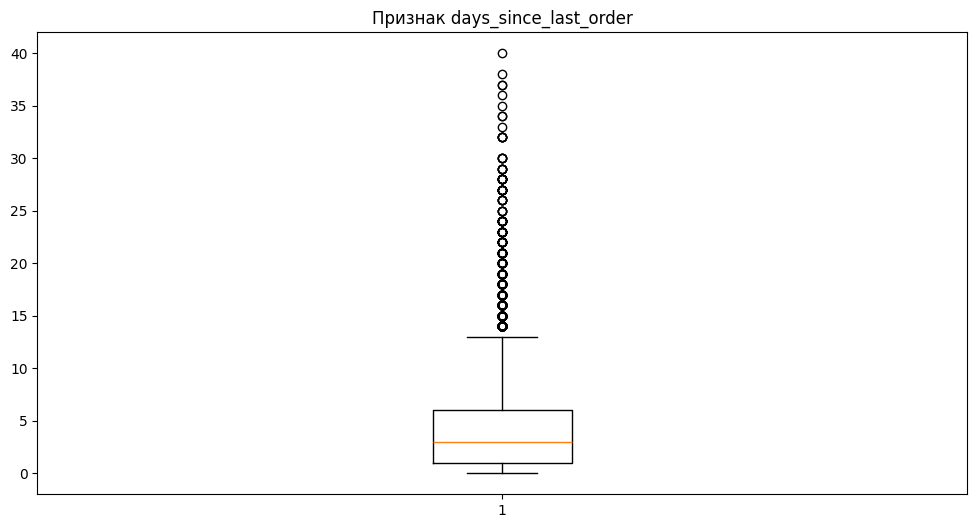

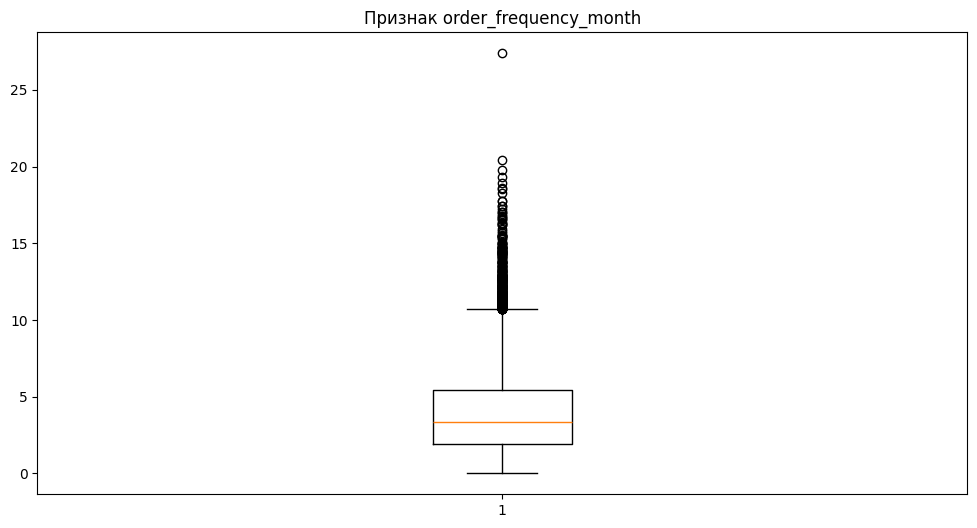

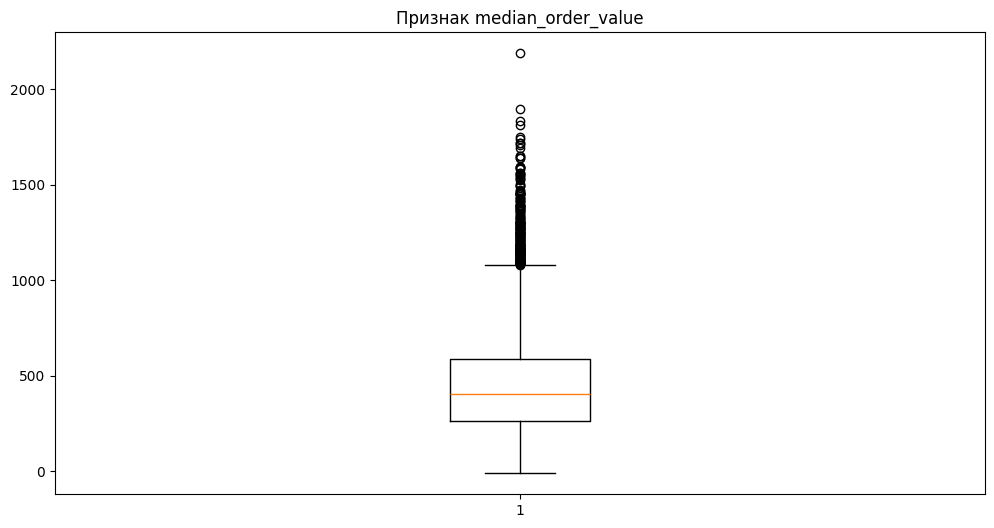

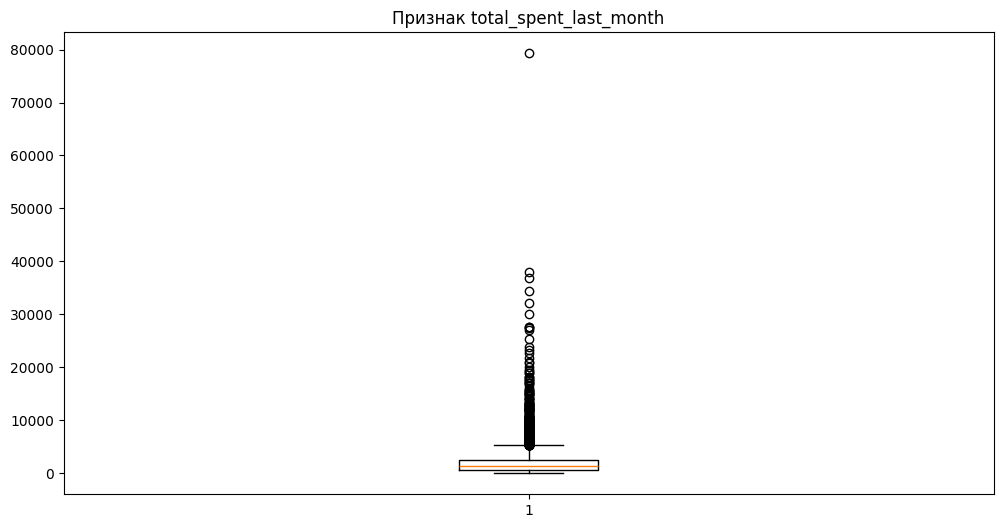

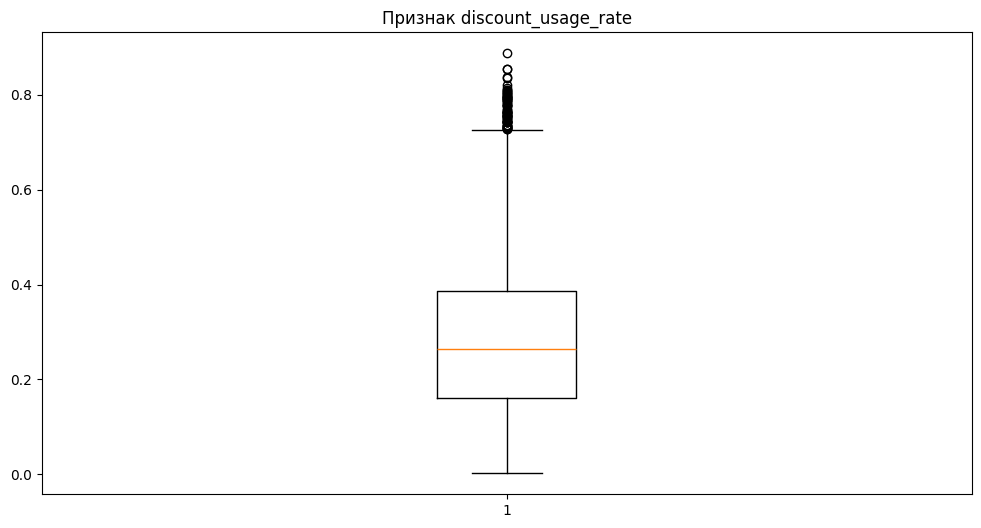

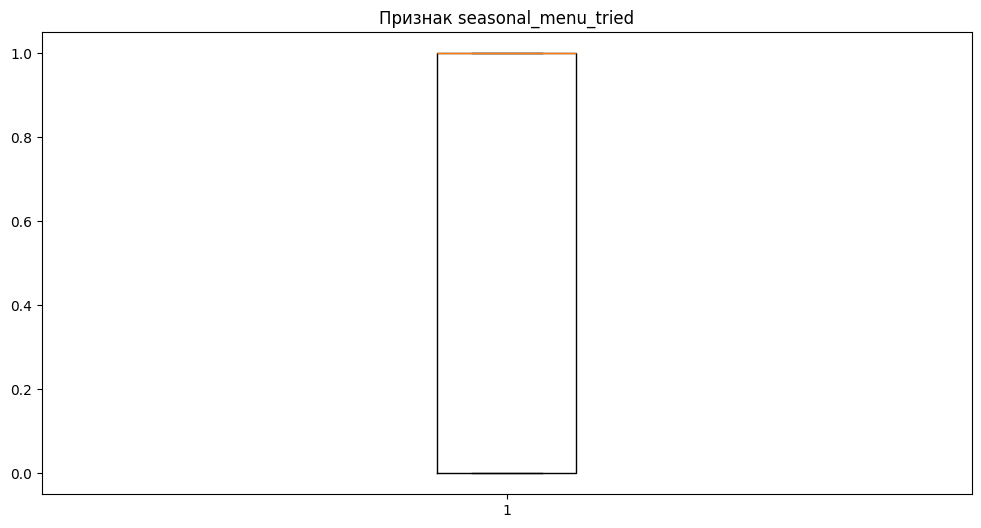

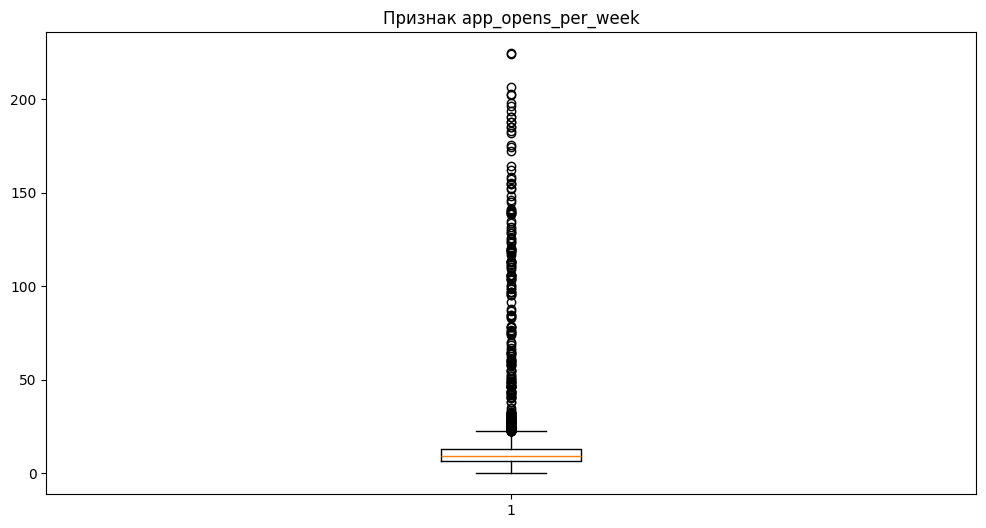

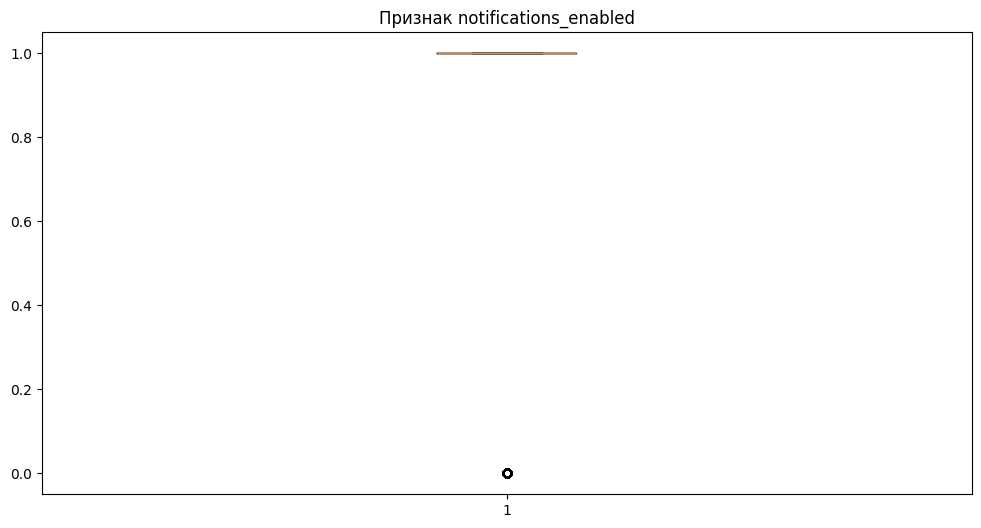

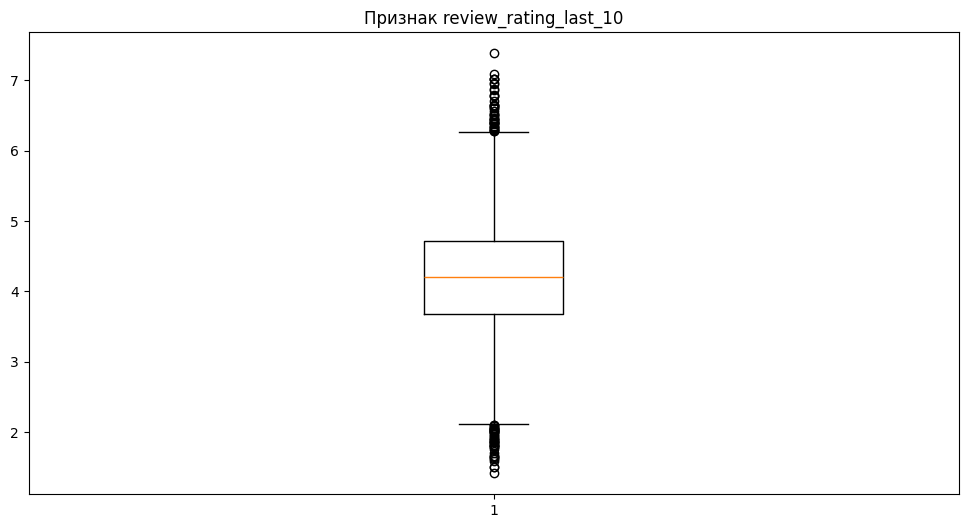

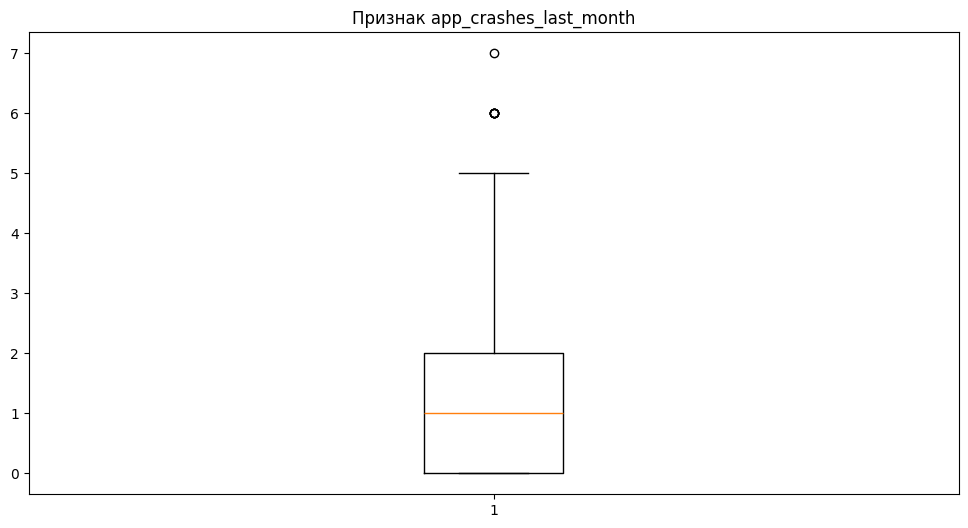

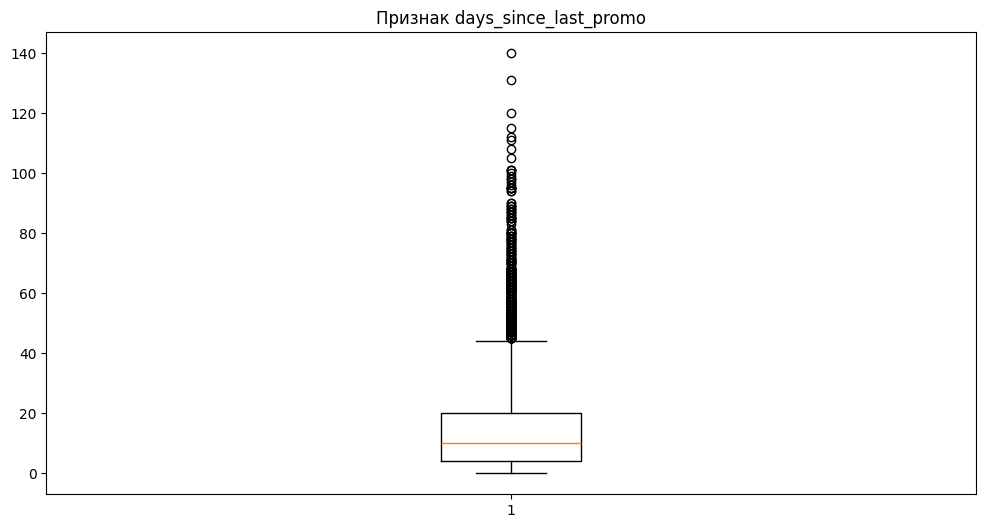

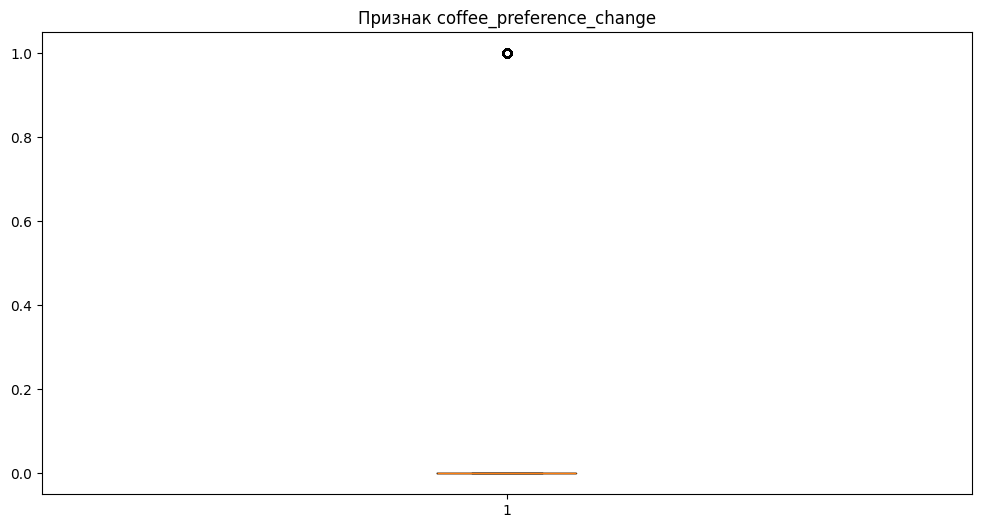

In [11]:
# 6. Изучение выбросов для признаков с помощью диаграмм размаха
for feature in num_features:
    plt.figure(figsize=(12, 6))
    plt.boxplot(df[feature].dropna())
    plt.title(f'Признак {feature}')
    plt.show()

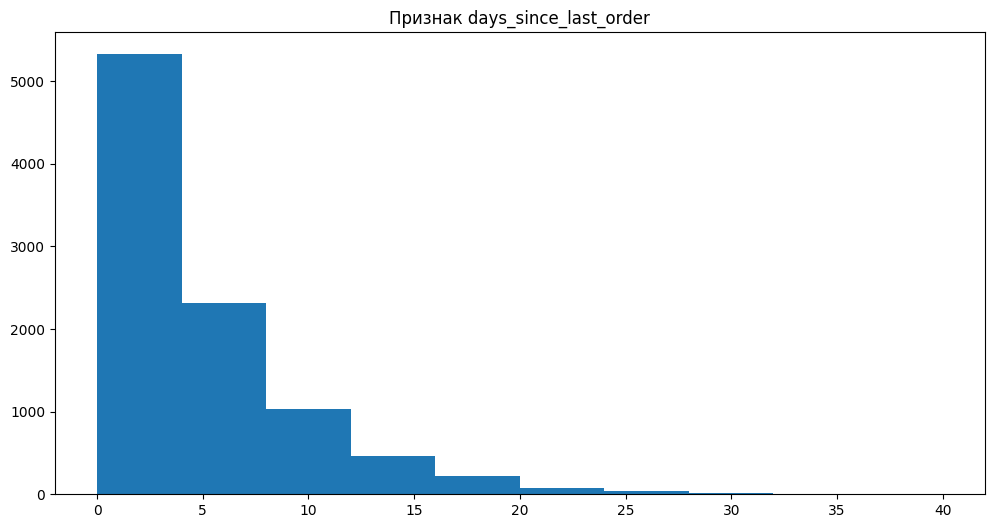

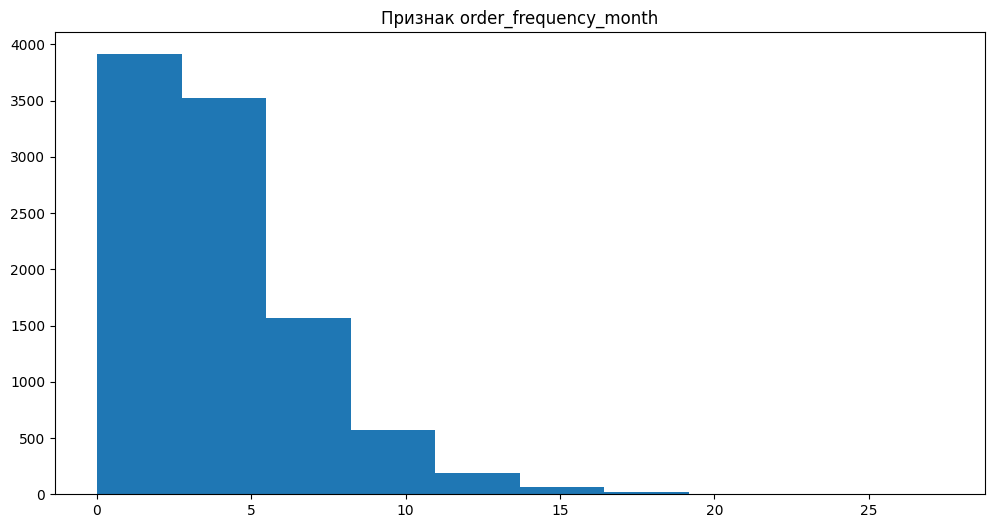

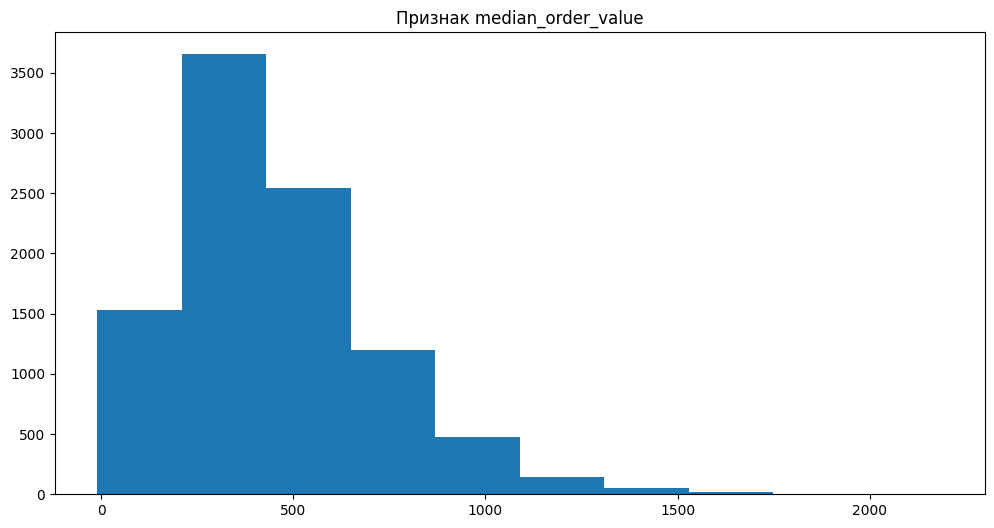

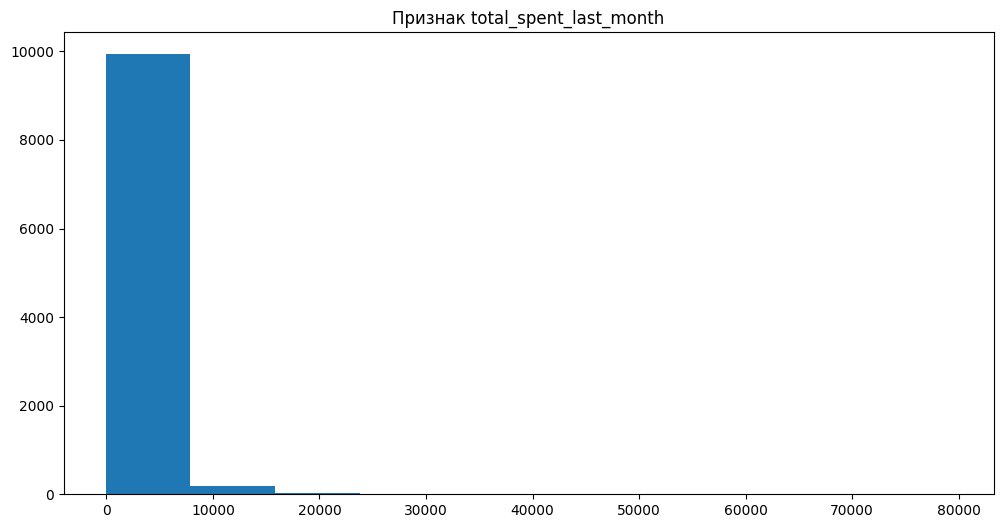

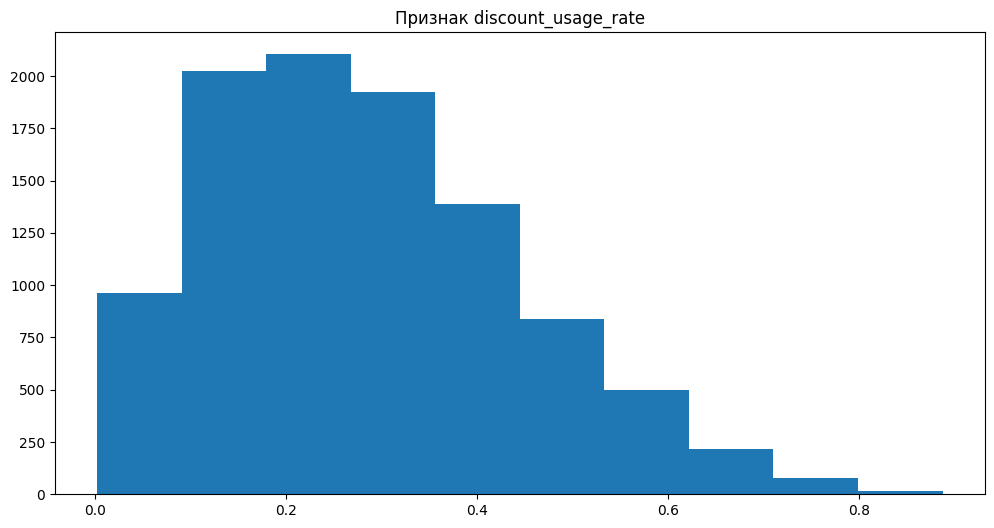

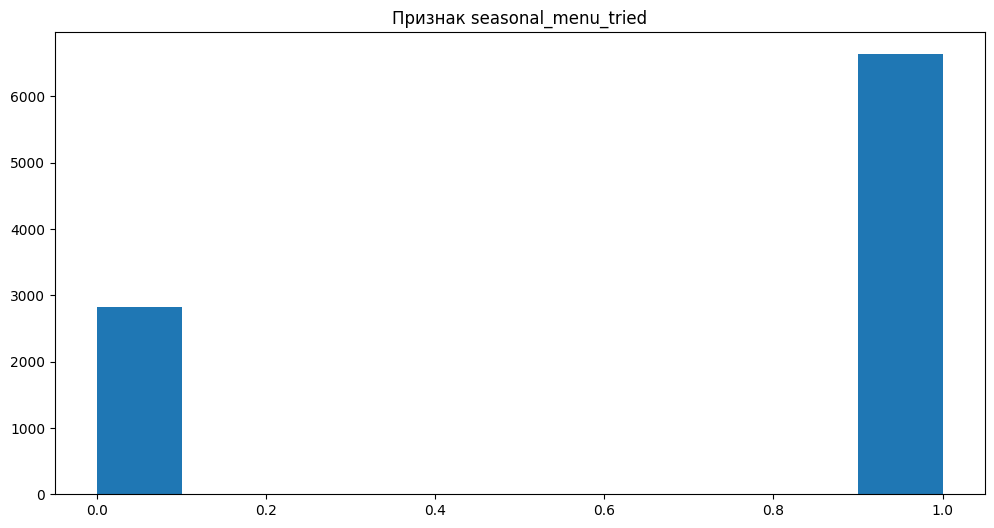

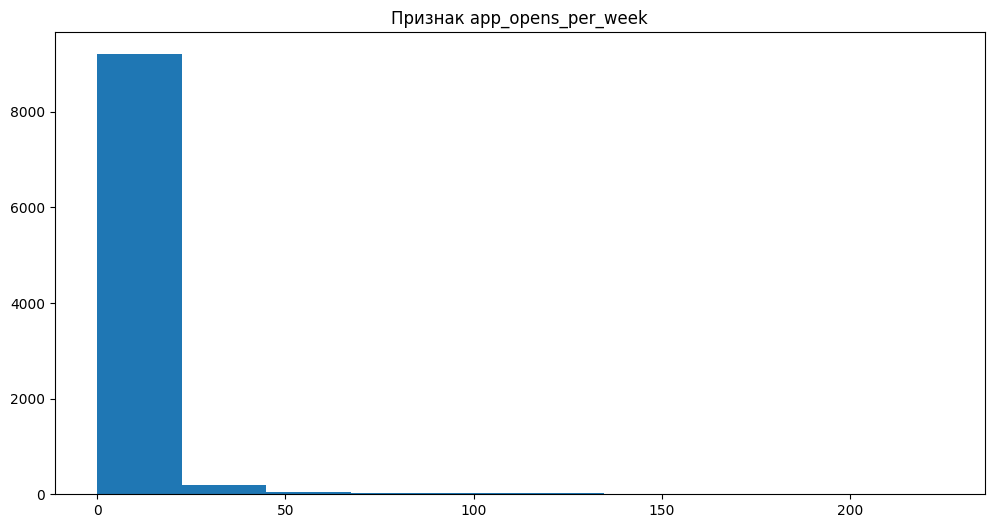

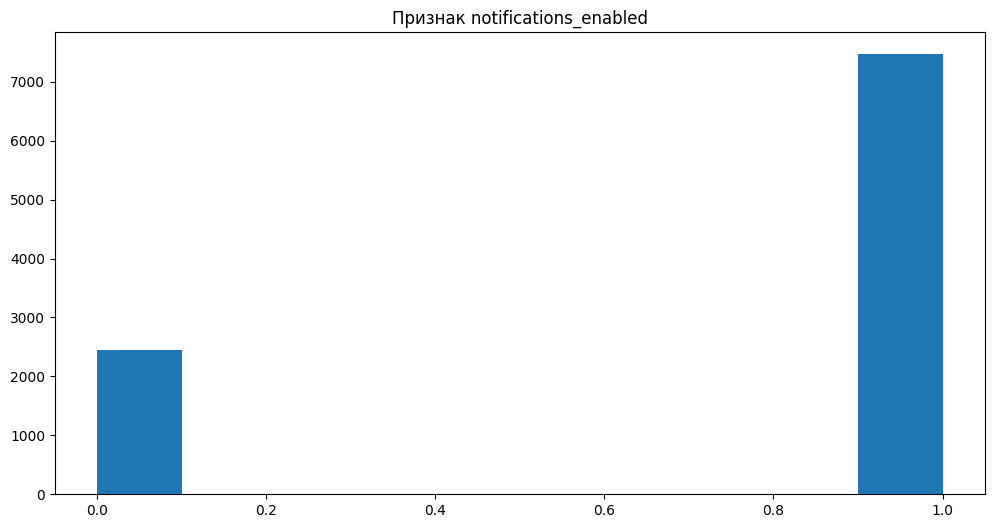

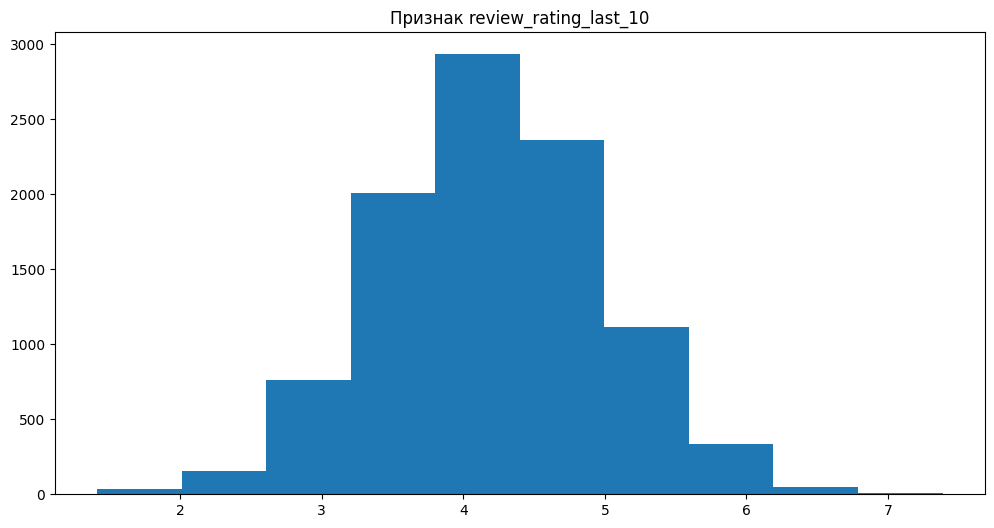

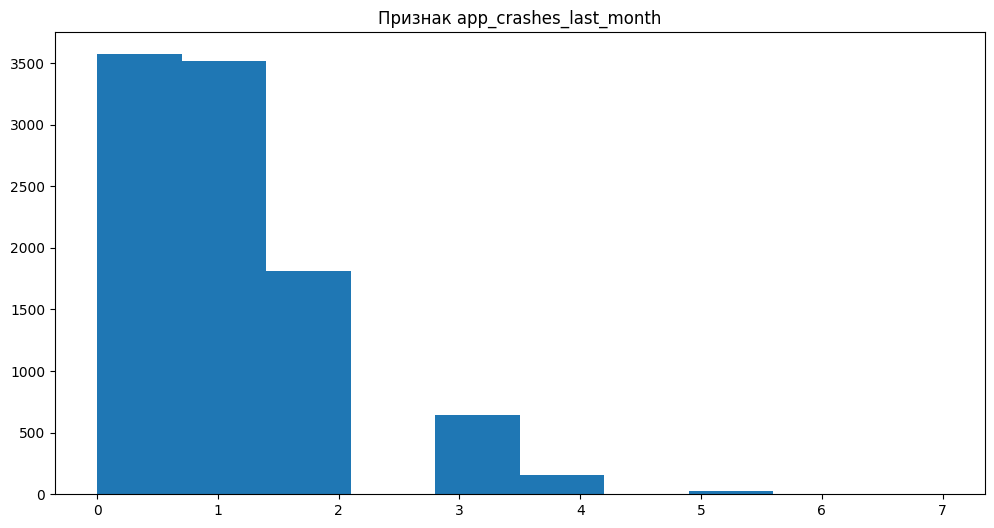

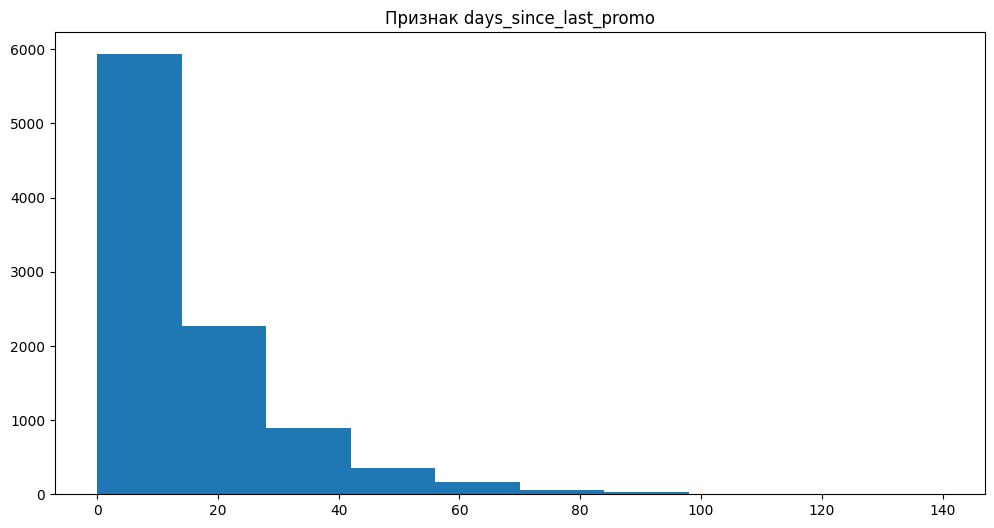

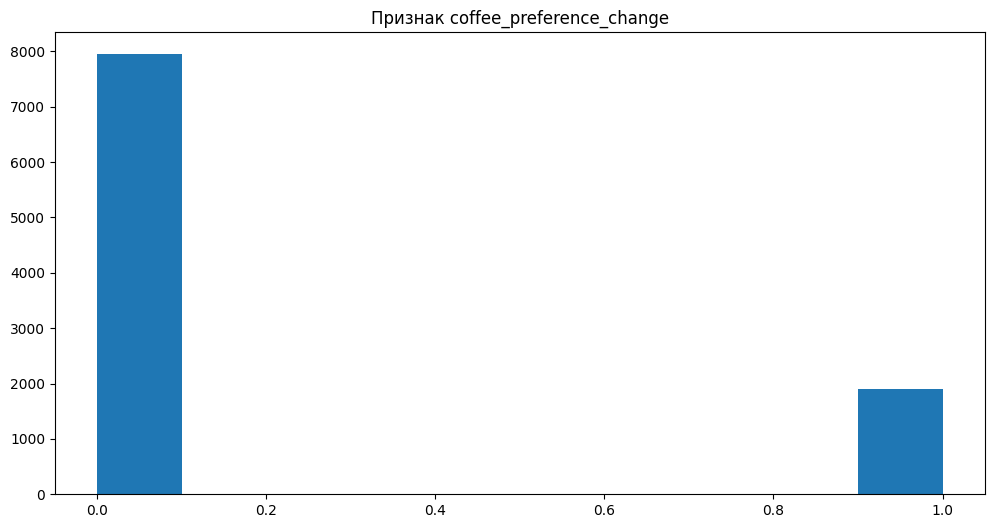

In [12]:
# 6. Изучение выбросов для признаков с помощью гистограмм
for feature in num_features:
    plt.figure(figsize=(12, 6))
    plt.hist(df[feature].dropna())
    plt.title(f'Признак {feature}')
    plt.show()

In [13]:
# 6. Исправление отрицательных значений в median_order_value и total_spent_last_month
df['median_order_value'] = np.abs(df['median_order_value'])
df['total_spent_last_month'] = np.abs(df['total_spent_last_month'])

interval columns not set, guessing: ['days_since_last_order', 'order_frequency_month', 'median_order_value', 'total_spent_last_month', 'discount_usage_rate', 'seasonal_menu_tried', 'app_opens_per_week', 'notifications_enabled', 'review_rating_last_10', 'app_crashes_last_month', 'days_since_last_promo', 'coffee_preference_change', 'churn']


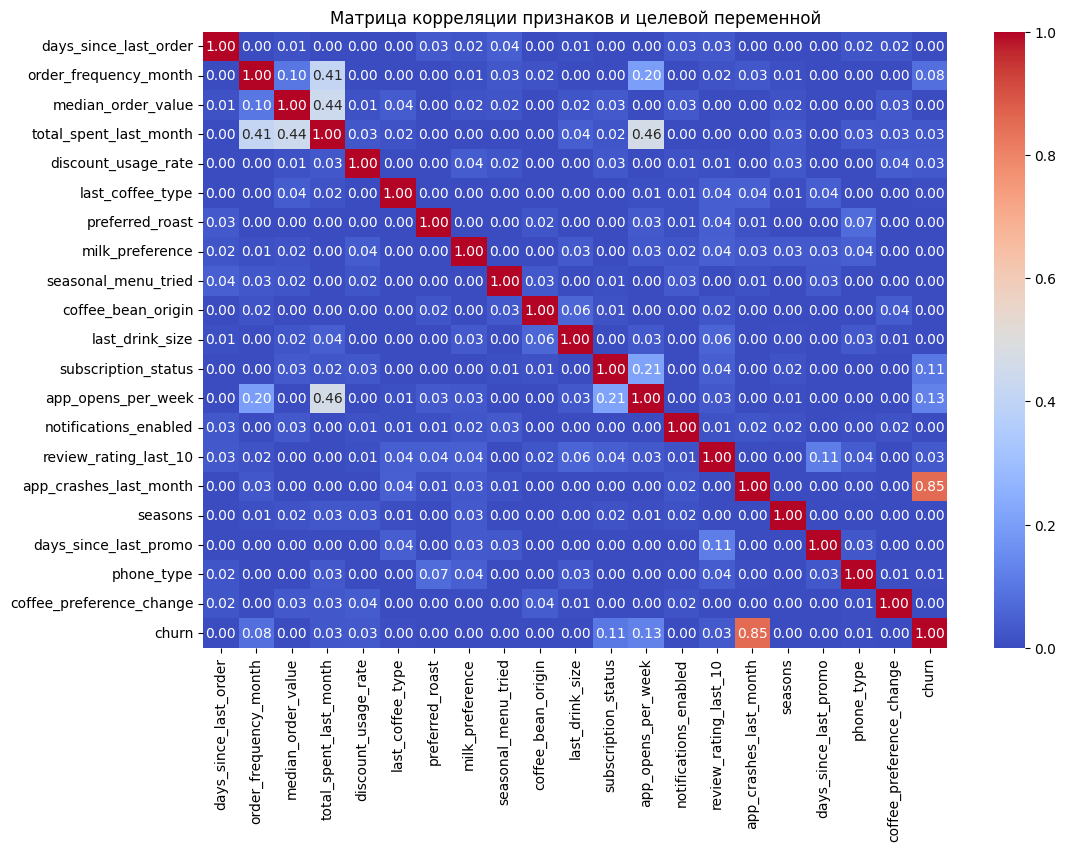

In [14]:
# 7. Матрица корреляции для датасета 
corr_matrix = df.phik_matrix()
plt.figure(figsize = (12,8))
sns.heatmap(corr_matrix,
            annot = True,
            fmt = '.2f',
            cmap = 'coolwarm')
plt.title('Матрица корреляции признаков и целевой переменной')
plt.show()

## Этап 3. Предобработка данных

1. Разделите данные в пропорции 80 к 20. 20% данных отложите для теста. Остальные используйте для обучения и кросс-валидации модели.

2. Предобработайте данные. Используйте информацию о пропусках и категориальных признаках только из обучающей выборки.

   - Создайте пайплайн, который обработает пропуски и выбросы.

   - Создайте пайплайн, который обработает категориальные признаки.

   - Создайте пайплайн, который обработает числовые признаки: проведёт масштабирование и нормализацию.



1) Датасет был разделен в пропорции 80 к 20. Также была проведена стратификация для корректного обучения и кросс-валидации. В итоге в каждой выборке получилось доля в 6% ушедших клиентов
2) Были созданы 2 пайплана: для обработки категориальных признаков cat_pipeline (вместе с обработкой пропусков) и для числовых признаков num_pipeline (аналогично с обработкой пропусков). Данные пайплайны далее были объединены в единый пайплайн с помощью ColumnTransformer. В basic_pipeline используется модель логистической регрессии с стандартными параметрами. В следующих этапах будут на основе cat_pipeline и num_pipeline создаваться пайплайны с dummy моделью и подобранными гиперпараметрами

In [15]:
# 1. Разделение данных на тестовую выборку и для кросс-валидации с последующим обучением
X = df.drop(columns = ['churn'])
y = df['churn']

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size = 0.2, shuffle = True, random_state = RANDOM_STATE, stratify = y)
print('Пример вывода признаков выборки для кросс-валидации и обучения')
display(X_train_val.head(5))
print('\nПример вывода целевых переменных выборки для кросс-валидации и обучения')
display(y_train_val[:5])

print('\n')
print(f'Доля данных с ушедшими клиентами на выборке для обучения и кросс-валидации: {y_train_val.sum()} или {round(y_train_val.sum() / y_train_val.count(),2)*100}%')
print(f'Доля данных с ушедшими клиентами на выборке для тестов: {y_test.sum()} или {round(y_test.sum() / y_test.count(),2)*100}%')

Пример вывода признаков выборки для кросс-валидации и обучения


,days_since_last_order,order_frequency_month,median_order_value,total_spent_last_month,discount_usage_rate,last_coffee_type,preferred_roast,milk_preference,seasonal_menu_tried,coffee_bean_origin,last_drink_size,subscription_status,app_opens_per_week,notifications_enabled,review_rating_last_10,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change
5424,0.0,5.692281,167.145725,775.622066,0.332092,blend,dark,none,1.0,kenya,medium,basic,16.987115,1.0,NaN,0.0,spring,5.0,android,1.0
9973,5.0,3.082845,482.760307,1574.378165,0.166546,arabica,light,none,1.0,kenya,medium,none,6.766912,1.0,4.064700,0.0,spring,2.0,ios,0.0
9137,NaN,3.960048,418.772312,1558.873026,0.068832,blend,dark,whole,1.0,vietnam,small,none,NaN,1.0,3.827217,0.0,spring,9.0,android,1.0
2379,NaN,3.206888,929.571103,3029.532022,0.257449,arabica,medium,whole,1.0,NaN,small,premium,NaN,1.0,4.247274,0.0,autumn,2.0,ios,0.0
7631,2.0,2.615352,264.877659,636.928615,0.275780,robusta,medium,almond,NaN,ethiopia,small,pro,11.165248,1.0,3.163397,NaN,spring,43.0,ios,0.0



Пример вывода целевых переменных выборки для кросс-валидации и обучения


5424    0
9973    0
9137    0
2379    0
7631    0
Name: churn, dtype: int64



Доля данных с ушедшими клиентами на выборке для обучения и кросс-валидации: 503 или 6.0%
Доля данных с ушедшими клиентами на выборке для тестов: 126 или 6.0%


In [16]:
# 2. Создание пайплайнов для предобработки датасета
num_features = ['days_since_last_order','order_frequency_month','median_order_value','total_spent_last_month','discount_usage_rate','seasonal_menu_tried','app_opens_per_week','notifications_enabled','review_rating_last_10','app_crashes_last_month','days_since_last_promo','coffee_preference_change']
cat_features = ['last_coffee_type','preferred_roast','milk_preference','coffee_bean_origin','last_drink_size','subscription_status','seasons','phone_type']

num_pipeline = Pipeline(steps = [
    ('Nan_values', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps = [
    ('Nan_values', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(sparse_output = False))
])

basic_preprocessing = ColumnTransformer(transformers = [
    ('num_features', num_pipeline, num_features),
    ('cat_features', cat_pipeline, cat_features)
])
basic_pipeline = Pipeline(steps = [
    ('preprocessing', basic_preprocessing),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

## Этап 4. Обучение модели

1. Обучите базовую версию модели.
   - Используйте для этого простые статистические модели.

   - Используйте кросс-валидацию для обучения модели.

2. Посчитайте метрики, поставленные в задаче. Опираясь на них, сделайте вывод о качестве модели.

Были созданы и 2 модели: дамми на базовом датасете (базовым я буду далее называть датасет без новых признаков) и логистическая регрессия также на базовом датасете с дефолтными гиперпараметрами. Уже на этом этапе по метрике PR-AUC можно заметить, что логистическая модель показывает метрику, которая в 11 раз лучше базовой dummy. На этом этапе модель уже имеет хорошие результаты, которые потенциально можно улучшить подбором гиперпараметров и улучшенным датасетом с новыми признаками. 

In [17]:
# Создание списка для хранения информации о моделях на кросс-валидации
models_info = []

In [18]:
# 1. Создание пайплайна с dummy моделью и ее метрика
dummy_pipeline = Pipeline(steps = [
    ('preprocessing', basic_preprocessing),
    ('model', DummyClassifier(random_state = RANDOM_STATE))
])



dummy_cv = cross_validate(
    estimator = dummy_pipeline,
    X = X_train_val,
    y = y_train_val,
    scoring = 'average_precision',
    cv = StratifiedKFold(n_splits = 5),
    n_jobs = -1
)

models_info.append(
    {
        'model': 'dummy',
        'dataset': 'basic',
        'PR_AUC': round(dummy_cv['test_score'].mean(),4),
        'param_C': 'default',
        'param_l1_ratio': 'default',
        'param_solver': 'default',
        'param_max_iter': 'default',
        'param_class_weight': "default"
    }
)
models_df = pd.DataFrame(models_info)
display(models_df)

,model,dataset,PR_AUC,param_C,param_l1_ratio,param_solver,param_max_iter,param_class_weight
0,dummy,basic,0.0602,default,default,default,default,default


In [19]:
# Расчет метрики для модели линейной регрессии с дефолтными гиперпараметрами на датасете с исходными признаками
basic_cv = cross_validate(
    estimator = basic_pipeline,
    X = X_train_val,
    y = y_train_val,
    scoring = 'average_precision',
    cv = StratifiedKFold(n_splits = 5),
    n_jobs = -1
)

models_info.append(
    {
        'model': 'LogReg',
        'dataset': 'basic',
        'PR_AUC': round(basic_cv['test_score'].mean(),4),
        'param_C': 'default',
        'param_l1_ratio': 'default',
        'param_solver': 'default',
        'param_max_iter': 'default',
        'param_class_weight': "default"
    }
)
models_df = pd.DataFrame(models_info)
display(models_df)

,model,dataset,PR_AUC,param_C,param_l1_ratio,param_solver,param_max_iter,param_class_weight
0,dummy,basic,0.0602,default,default,default,default,default
1,LogReg,basic,0.6630,default,default,default,default,default


## Этап 5. Создание новых признаков

1. Добавьте новые признаки, которые могут улучшить качество модели. Опирайтесь на наработки, полученные в ходе исследовательского анализа данных, и на логику решаемой задачи.

   - Извлечение квадратного корня поможет сгладить большие значения.

   - Возведение в квадрат усилит влияние больших значений.

2. Обновите пайплайн для работы с новыми признаками, проведите повторную кросс-валидацию, сравните результаты моделей с новыми признаками и без них.

3. Интерпретируйте коэффициенты модели, а затем на их основании выявите значимые признаки и удалите лишние для модели.

1) Была идея о создании признака "премиального" клиента, то есть того, кто покупал премиальный сорт кофе, происхождение зерна было также из "премиальных" в рамках кофе стран, покупались большие напитки, а статус подписки был pro или premium. Однако процент таких клиентов в датасете оказался слишком малым (3.59%), а корреляция с целевой переменной составляет всего 0.01. Следовательно, рассматривать такой признак не стоит: он бесполезен, но при этом может вызвать переобучение.

   В итоге было решено из новых признаков применить логарифмирование к: total_spent_last_month, app_opens_per_week. Квадратный корень к: order_frequency_month. При этом сами эти исходные признаки перезаписываются.
2) Получившаяся модель в результате кросс-валидации улучшила свои метрики по сравнению с той же моделью на базовом датасете. Ранее было значение 0.66, теперь оно стало 0.68. Это не большое улучшение, но оно присутствует.
3) Числовые days_since_last_order (вес 0.031), discount_usage_rate (0.016 по модулю), coffee_preference_change (0.035) и категорильальные last_drink_size (максимльное 0.076 среди столбцов после кодировки), seasons (0.058 максимум). Данные признаки имеют слишком малые веса по сравнению с максимальным по модулем весом (2.23). Поэтому их стоит удалить, чтобы не усложнять модель. В результате удаления метрика модели незначительно улучшилась до 0.69.

In [20]:
# Создание нового бинарного признака "премиальности" клиента
df['is_premium'] = (
    (df['last_coffee_type'] == 'arabica') &
    df['coffee_bean_origin'].isin(['ethiopia', 'kenya']) &
    (df['last_drink_size'].isin(['large','medium'])) &
    df['subscription_status'].isin(['premium', 'pro'])
).astype(int)
print(f'Премиальных клиентов: {df['is_premium'].sum()} или {round(df['is_premium'].sum() / df.shape[0] * 100,2)}%\n')

Премиальных клиентов: 375 или 3.59%



interval columns not set, guessing: ['days_since_last_order', 'order_frequency_month', 'median_order_value', 'total_spent_last_month', 'discount_usage_rate', 'seasonal_menu_tried', 'app_opens_per_week', 'notifications_enabled', 'review_rating_last_10', 'app_crashes_last_month', 'days_since_last_promo', 'coffee_preference_change', 'churn', 'is_premium']


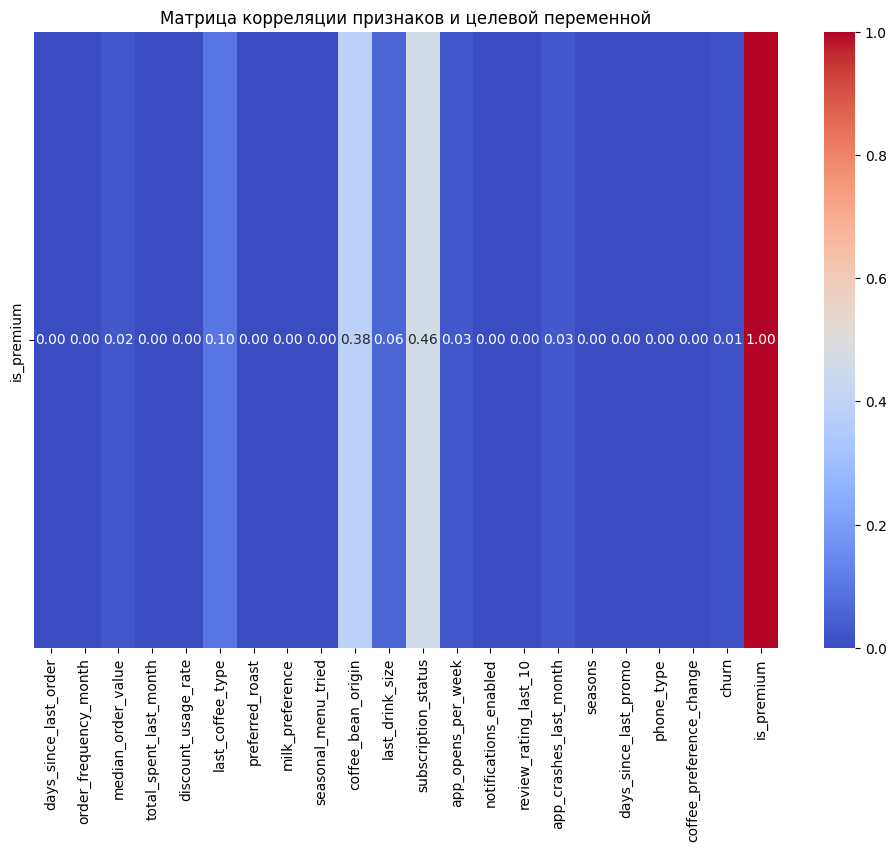

In [21]:
# Матрица корреляции для нового признака
corr_matrix = df.phik_matrix()
plt.figure(figsize = (12,8))
sns.heatmap(corr_matrix.loc[['is_premium']],
            annot = True,
            fmt = '.2f',
            cmap = 'coolwarm')
plt.title('Матрица корреляции признаков и целевой переменной')
plt.show()

In [22]:
# Создание датасета с новыми признаками и разделение на выборки
new_df = df.copy()

new_df['total_spent_last_month'] = np.log1p(new_df['total_spent_last_month'])
new_df['app_opens_per_week'] = np.log1p(new_df['app_opens_per_week'])
new_df['order_frequency_month'] = np.sqrt(new_df['order_frequency_month'])

new_df.info()

new_X = new_df.drop(['churn'], axis = 1)
new_y = new_df['churn']

new_X_train_val, new_X_test, new_y_train_val, new_y_test = train_test_split(new_X,
                                                                            new_y,  
                                                                            test_size = 0.2, 
                                                                            shuffle = True, 
                                                                            random_state = RANDOM_STATE, 
                                                                            stratify = y
                                                                           )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   days_since_last_order     9505 non-null   float64
 1   order_frequency_month     9850 non-null   float64
 2   median_order_value        9619 non-null   float64
 3   total_spent_last_month    10156 non-null  float64
 4   discount_usage_rate       10053 non-null  float64
 5   last_coffee_type          10192 non-null  object 
 6   preferred_roast           10334 non-null  object 
 7   milk_preference           9782 non-null   object 
 8   seasonal_menu_tried       9461 non-null   float64
 9   coffee_bean_origin        9768 non-null   object 
 10  last_drink_size           9946 non-null   object 
 11  subscription_status       9512 non-null   object 
 12  app_opens_per_week        9554 non-null   float64
 13  notifications_enabled     9913 non-null   float64
 14  review

In [23]:
# 2. Расчет и оценка метрик модели на датасете с новыми признаками и дефолтными параметрами. 
new_cv = cross_validate(
    estimator = basic_pipeline,
    X = new_X_train_val,
    y = new_y_train_val,
    scoring = 'average_precision',
    cv = StratifiedKFold(n_splits = 5),
    n_jobs = -1
)

models_info.append(
    {
        'model': 'LogReg',
        'dataset': 'new',
        'PR_AUC': round(new_cv['test_score'].mean(),4),
        'param_C': 'default',
        'param_l1_ratio': 'default',
        'param_solver': 'default',
        'param_max_iter': 'default',
        'param_class_weight': "default"
    }
)
models_df = pd.DataFrame(models_info)
display(models_df)

,model,dataset,PR_AUC,param_C,param_l1_ratio,param_solver,param_max_iter,param_class_weight
0,dummy,basic,0.0602,default,default,default,default,default
1,LogReg,basic,0.6630,default,default,default,default,default
2,LogReg,new,0.6858,default,default,default,default,default


In [24]:
# 3. Анализ весов модели на улучшенном датасете
basic_pipeline.fit(new_X_train_val,new_y_train_val)

trained_model = basic_pipeline.named_steps['model']
preprocessor = basic_pipeline.named_steps['preprocessing']

coefs = trained_model.coef_[0]
feature_names = preprocessor.get_feature_names_out()

feature_weights = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_coefficient': np.abs(coefs)
})
display(feature_weights)
print('\nТаблица с сортировкой по убыванию значения весов по модулю\n')
display(feature_weights.sort_values('abs_coefficient', ascending=False))

,feature,coefficient,abs_coefficient
0,num_features__days_since_last_order,0.030779,0.030779
1,num_features__order_frequency_month,0.574433,0.574433
2,num_features__median_order_value,0.171932,0.171932
3,num_features__total_spent_last_month,-0.364937,0.364937
4,num_features__discount_usage_rate,-0.015726,0.015726
5,num_features__seasonal_menu_tried,-0.163979,0.163979
6,num_features__app_opens_per_week,0.723432,0.723432
7,num_features__notifications_enabled,-0.059598,0.059598
8,num_features__review_rating_last_10,-0.085868,0.085868
9,num_features__app_crashes_last_month,2.223400,2.223400



Таблица с сортировкой по убыванию значения весов по модулю



,feature,coefficient,abs_coefficient
9,num_features__app_crashes_last_month,2.223400,2.223400
6,num_features__app_opens_per_week,0.723432,0.723432
36,cat_features__subscription_status_pro,0.594856,0.594856
1,num_features__order_frequency_month,0.574433,0.574433
3,num_features__total_spent_last_month,-0.364937,0.364937
19,cat_features__milk_preference_none,-0.343357,0.343357
33,cat_features__subscription_status_basic,-0.341728,0.341728
18,cat_features__milk_preference_almond,0.323293,0.323293
34,cat_features__subscription_status_none,-0.221124,0.221124
14,cat_features__last_coffee_type_robusta,0.190590,0.190590


In [25]:
# 4. Удаление признаков с малым весом и кросс-валидация модели на оптимизированном (в плане признаков) датасете
new_opt_df = new_df.copy()
new_opt_df = new_opt_df.drop(columns = ['days_since_last_order','discount_usage_rate','coffee_preference_change','last_drink_size','seasons'])

new_opt_X = new_opt_df.drop(['churn'], axis = 1)
new_opt_y = new_opt_df['churn']

new_opt_X_train_val, new_opt_X_test, new_opt_y_train_val, new_opt_y_test = train_test_split(new_opt_X,
                                                                            new_opt_y,  
                                                                            test_size = 0.2, 
                                                                            shuffle = True, 
                                                                            random_state = RANDOM_STATE, 
                                                                            stratify = y
                                                                           )



In [26]:
# Создание нового пайплайна для датасета с оптимизированным кол-вом признаков
new_num_features = ['order_frequency_month','median_order_value','total_spent_last_month','seasonal_menu_tried','app_opens_per_week','notifications_enabled','review_rating_last_10','app_crashes_last_month','days_since_last_promo']
new_cat_features = ['last_coffee_type','preferred_roast','milk_preference','coffee_bean_origin','subscription_status','phone_type']

new_preprocessing = ColumnTransformer(transformers = [
    ('num_features', num_pipeline, new_num_features),
    ('cat_features', cat_pipeline, new_cat_features)
])
new_pipeline = Pipeline(steps = [
    ('preprocessing', new_preprocessing),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

In [27]:
# 4. Расчет метрики модели на оптимизированном датасете с новыми признаками
new_opt_cv = cross_validate(
    estimator = new_pipeline,
    X = new_opt_X_train_val,
    y = new_opt_y_train_val,
    scoring = 'average_precision',
    cv = StratifiedKFold(n_splits = 5),
    n_jobs = -1
)

models_info.append(
    {
        'model': 'LogReg',
        'dataset': 'new_optimized',
        'PR_AUC': round(new_opt_cv['test_score'].mean(),4),
        'param_C': 'default',
        'param_l1_ratio': 'default',
        'param_solver': 'default',
        'param_max_iter': 'default',
        'param_class_weight': "default"
    }
)
models_df = pd.DataFrame(models_info)
display(models_df)

,model,dataset,PR_AUC,param_C,param_l1_ratio,param_solver,param_max_iter,param_class_weight
0,dummy,basic,0.0602,default,default,default,default,default
1,LogReg,basic,0.6630,default,default,default,default,default
2,LogReg,new,0.6858,default,default,default,default,default
3,LogReg,new_optimized,0.6925,default,default,default,default,default


## Этап 6. Эксперименты с гиперпараметрами

1. Перечислите все гиперпараметры, с которыми планируете экспериментировать.

2. Проведите систематический перебор гиперпараметров для `LogisticRegression`, выполните кросс-валидацию для каждой конфигурации.

3. Составьте таблицу с результатами.

4. Выберите лучшую модель, ориентируясь на заданную метрику качества.

Было решено работать с такими гиперпараметрами: C, l1_ratio, solver, max_iter, class_weight. С помощью GridSearch были перебраны все возможные комбинации гиперпараметров. В итоге лучшей моделью стала LogisticRegression с параметрами C = 0.01, l1_ratio = 1, solver = liblinear, max_iter = 100, class_weight = None. В результате PR-AUC данной модели стало 0.70 (предыдущий результат на том же датасете, но с дефолтными гиперпараметрами составлял 0.69)

In [28]:
# Создание списка для GridSearchCV
params_grid = [
    {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__l1_ratio': [0, 1],
    'model__solver': ['liblinear', 'saga'],  
    'model__max_iter': [100, 200, 500, 1000],
    'model__class_weight': [None, 'balanced']
    }
]


In [29]:
# Применение GridSearch для поиска лучшей модели 
grid_model = GridSearchCV(
    estimator = new_pipeline,
    param_grid = params_grid,
    scoring = 'average_precision',
    n_jobs = -1,
    cv = StratifiedKFold(n_splits = 5)
)

grid_model.fit(new_opt_X_train_val, new_opt_y_train_val)

params = grid_model.best_params_

score = grid_model.best_score_

display(params)

{'model__C': 0.01,
 'model__class_weight': None,
 'model__l1_ratio': 1,
 'model__max_iter': 100,
 'model__solver': 'liblinear'}

In [30]:
models_info.append(
    {
        'model': 'LogReg',
        'dataset': 'new_optimized',
        'PR_AUC': round(score,4),
        'param_C': params['model__C'],
        'param_l1_ratio': params['model__l1_ratio'],
        'param_solver': params['model__solver'],
        'param_max_iter': params['model__max_iter'],
        'param_class_weight': params['model__class_weight']
    }
)
models_df = pd.DataFrame(models_info)
display(models_df)

,model,dataset,PR_AUC,param_C,param_l1_ratio,param_solver,param_max_iter,param_class_weight
0,dummy,basic,0.0602,default,default,default,default,default
1,LogReg,basic,0.6630,default,default,default,default,default
2,LogReg,new,0.6858,default,default,default,default,default
3,LogReg,new_optimized,0.6925,default,default,default,default,default
4,LogReg,new_optimized,0.7024,0.01,1,liblinear,100,None


## Этап 7. Подготовка финальной модели

Объедините лучшую конфигурацию гиперпараметров с оптимальным набором признаков. Обучите модель на всех данных для кросс-валидации и проведите финальную оценку на отложенной тестовой выборке.


In [31]:
# Создание пайплайна лучшей модели
new_pipeline = Pipeline(steps = [
    ('preprocessing', new_preprocessing),
    ('model', LogisticRegression(random_state=42,
                                 l1_ratio = 1,
                                 solver = 'liblinear',
                                 max_iter = 100,
                                 C = 0.01
                                ))
])

In [40]:
# Обучение модели с лучшими гиперпараметрами и датасетом на всей обучающей выборке
new_pipeline.fit(new_opt_X_train_val, new_opt_y_train_val)

y_pred = new_pipeline.predict_proba(new_opt_X_test)[:,1]

test_pr_auc = average_precision_score(new_opt_y_test, y_pred)

print('Лучшая модель LogisticRegression:')
print(f'Метрика на кросс-валидации: {models_df[models_df['PR_AUC'] == models_df['PR_AUC'].max()]['PR_AUC'].values[0]}')
print(f'Метрика на тестовой выборке: {round(test_pr_auc,2)}')

Лучшая модель LogisticRegression:
Метрика на кросс-валидации: 0.7024
Метрика на тестовой выборке: 0.73


## Этап 8. Отчёт о проделанной работе

Проанализируйте итоговые метрики модели и факторы, которые на них повлияли. Составьте описание, выделив наиболее важные факторы.

В результате работы датасет, имеющий изначально 27 столбцов (26 признаков), после удаления имел 17 столбцов (16 признаков). Никакие строки при этом удалены не были, так как было важно сохранить как можно больше данных из-за малого количества записей об ушедших клиентах.

В результате анализа данных были обнаружены пропуски во всех столбцах датасета (не считая целевой переменной). В числовых признаках пропуски были заменены медианой, в категориальных - модой. 

Все выбросы в признаках имели в целом реальные данные, поэтому было решено строки с выбросами также не удалять и оставить. Но в дальнейшем к некоторым признакам с выбросами были применены логарифмирование или взятие квадратного корня для сглаживания больших значений. 

Была создана dummy модель, которая являлась ориентиром для следующих моделей по качеству метрики PR-AUC. Уже первая модель логистической регрессии на предобработанном датасете, но с дефолтными гиперпараметрами и без новых признаков, показала хорошие результаты (0.66), превышающие базовую дамми. Далее в датасет были добавлены новые признаки (с помощью логарифмирования и квадратного корня), после которых метрика PR-AUC незначительно, но улучшилась на кросс-валидации. Была попытка создать новый признак "премиального" клиента, но матрица корреляции показала, что данная идея неэффективна. 

С помощью перебора гиперпараметров через GridSearchCV были найдены лучшие гиперпараметры для модели.
В итоге лучшей моделью оказалась LogisticRegression с подобранными через GridSearchCV гиперпараметрами на предобработанном датасете, в котором были добавлены новые признаки, удалены ненужные. На кросс-валидации данная модель показала значение PR-AUC 0.70, что уже является очень хорошим результатом. Далее эта модель была обучена на всем обучающем датасете и была рассчитана PR-AUC на тестовой выборке. Результатом стало значение 0.73, что показывает результаты, превосходящие кросс-валидационную выборку (возможно, просто тестовый датасет оказался немного "легче" валидационного). Это означает, что модель обучилась хорошо, переобучение отсутствует. 
Наиболее важными факторами являются удаление ненужных признаков, обработка пропусков, создание новых признаков (в данном случае через сглаживание некоторых исходных через логарифмирование и квадратный корень) и подбор гиперпараметров. Текущая модель рекомендуется к использованию заказчиком и будет сохранена для продакшена. 

## Этап 9. Сохранение модели для продакшена

Сохраните итоговую модель и пайплайн предобработки. Убедитесь, что всё работает: загрузите артефакты и проверьте их на тестовых данных. В решении укажите ссылку для скачивания сохранённых файлов.

Пайплайн был успешно сохранен и загружен через joblib. Метрики на тестовой выборке загруженной модели аналогичны тому, что получилось ранее. Также для теста был заново загружен необработанный датасет и добавлен в загруженный пайплайн. Метрика в 0.71 показывает, что предобработка датасета прошла нормально. 
Скачать файл пайплайна и эти тетрадь можно через GitHub по ссылке: https://github.com/sol2033/project-11-LogisticRegression-Yandex/tree/main

In [41]:
# Создание итогового пайплайна с полной предобработкой датасета (в том числе с удалением ненужных признаков и добавлением новых)
def preprocess_data(df):
    prep_df = df.copy()
    
    columns_to_delete = ['geo_location',
                         'user_id',
                         'order_frequency_week',
                         'total_spent_last_week',
                         'avg_order_value',
                         'review_rating_last_1',
                         'days_since_last_order',
                         'discount_usage_rate',
                         'coffee_preference_change',
                         'last_drink_size',
                         'seasons'
                        ]
    prep_df = prep_df.drop(columns = columns_to_delete)
    
    prep_df['median_order_value'] = np.abs(prep_df['median_order_value'])
    prep_df['total_spent_last_month'] = np.abs(prep_df['total_spent_last_month'])

    prep_df['total_spent_last_month'] = np.log1p(prep_df['total_spent_last_month'])
    prep_df['app_opens_per_week'] = np.log1p(prep_df['app_opens_per_week'])
    prep_df['order_frequency_month'] = np.sqrt(prep_df['order_frequency_month'])

    return prep_df

full_pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(preprocess_data)), 
    ('preprocessing', new_pipeline.named_steps['preprocessing']),   
    ('model', new_pipeline.named_steps['model'])                    
])

In [44]:
# Сохранение пайплайна и модели. Загрузка модели и пайплайна и проверка на тестовой выборке
joblib.dump(full_pipeline,'full_pipeline.pkl')

loaded_pipeline = joblib.load('full_pipeline.pkl')

y_pred = loaded_pipeline[1:].predict_proba(new_opt_X_test)[:, 1]
test_pr_auc = average_precision_score(new_opt_y_test, y_pred)

print('Загруженная модель LogisticRegression:')
print(f'Метрика на тестовой выборке: {round(test_pr_auc,2)}')

Загруженная модель LogisticRegression:
Метрика на тестовой выборке: 0.73


In [47]:
# Рассчет метрики на всём непредобработанном датасете (для тестирования работы препроцессинга)
df = pd.read_csv('https://code.s3.yandex.net/datasets/coffee_churn_dataset.csv', sep = ',', decimal = '.')

X = df.drop(['churn'], axis = 1)
y = df['churn']

y_pred = loaded_pipeline.predict_proba(X)[:, 1]
pr_auc = average_precision_score(y, y_pred)

print('Загруженная модель LogisticRegression:')
print(f'Метрика на всем датасете: {round(pr_auc,2)}')

Загруженная модель LogisticRegression:
Метрика на всем датасете: 0.71
